### In the first part of the script we are gonna create and save in directory ''./part'' the partial datasets, that are the result of the pivoting of ONE indicator, taken from Indicators.csv.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import pymongo

In [2]:
from pymongo import MongoClient

conn = MongoClient()

In [3]:
db = conn.Db_Progetto

In [2]:
# indicators = pd.read_csv("dataset/Indicators.csv")

In [3]:
# indicators.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,1.335609e+02
1,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,8.779760e+01
2,Arab World,ARB,"Age dependency ratio, old (% of working-age po...",SP.POP.DPND.OL,1960,6.634579e+00
3,Arab World,ARB,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,1960,8.102333e+01
4,Arab World,ARB,Arms exports (SIPRI trend indicator values),MS.MIL.XPRT.KD,1960,3.000000e+06


#### Select the indicator that I want


In [23]:
indic_list = 'SP.POP.TOTL'
# indicators = indicators[indicators.IndicatorCode.isin(indic_list)]
indicators = pd.DataFrame(list(db.Indicators.find({"IndicatorCode" : indic_list })), dtype = np.float)

In [24]:
del indicators['_id']

In [25]:
indicators.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,"Population, total",SP.POP.TOTL,1960.0,9.249590e+07
1,Caribbean small states,CSS,"Population, total",SP.POP.TOTL,1960.0,4.190810e+06
2,Central Europe and the Baltics,CEB,"Population, total",SP.POP.TOTL,1960.0,9.140158e+07
3,East Asia & Pacific (all income levels),EAS,"Population, total",SP.POP.TOTL,1960.0,1.042475e+09
4,East Asia & Pacific (developing only),EAP,"Population, total",SP.POP.TOTL,1960.0,8.964930e+08


#### I do the pivoting, obtaining a dataset with 3 columns: Value of the indicator, CountryCode and Year

In [26]:
indicators2 = indicators.pivot(columns='IndicatorCode', values=['Value','CountryCode','Year'])

In [27]:
indicators2.shape


(13484, 3)

In [28]:
indicators2.head(10)

,Value,CountryCode,Year
IndicatorCode,SP.POP.TOTL,SP.POP.TOTL,SP.POP.TOTL
0,9.24959e+07,ARB,1960
1,4.19081e+06,CSS,1960
2,9.14016e+07,CEB,1960
3,1.04248e+09,EAS,1960
4,8.96493e+08,EAP,1960
5,2.65397e+08,EMU,1960
6,6.67489e+08,ECS,1960
7,1.55317e+08,ECA,1960
8,4.09498e+08,EUU,1960


##### Renaming the columns

In [29]:
indicators2.columns = [' '.join(col).strip() for col in indicators2.columns.values]

In [30]:
indicators2.columns = [indicators2.columns[0].split()[1], 'CountryCode', 'Year']


In [52]:
indicators2.head()

,SP.POP.TOTL,CountryCode,Year
0,9.24959e+07,ARB,1960
1,4.19081e+06,CSS,1960
2,9.14016e+07,CEB,1960
3,1.04248e+09,EAS,1960
4,8.96493e+08,EAP,1960


##### Saving the dataset (note: you have to change the name)

##### Con questa soluzione bisogna cambiare a mano tutti i nomi perchè MongoDB non vuole i punti all'interno dei nomi delle colonne, tutavia bisognerebbe cambiare tutto il file per adattarlo. In questo caso ho fatto la prova con Urban Population cambiando a mano i nomi.

In [61]:
# indicators2.to_csv(path_or_buf='./part/pop_tot')

indicators2.columns = ['UrbPopulation','CountryCode','Year']

import json

collection = db['UrbPopulation']
print("Collection created")

records = json.loads(indicators2.T.to_json()).values()
db.UrbPopulation.insert_many(records) #columns name must not be with points

Collection created


###  Repeat the rows above FOR EACH indicator that you want to have in the final dataset. After all the creations I reload and merge them, below.

In [13]:
birth = pd.read_csv("./part/birth")
life = pd.read_csv("./part/arms_import")
arms = pd.read_csv("./part/life_expect")
rural = pd.read_csv("./part/rural")
urban = pd.read_csv("./part/urban")
mrF = pd.read_csv("./part/mort_rateF")
mrM = pd.read_csv("./part/mort_rateM")

In [14]:
del birth['Unnamed: 0']
del arms['Unnamed: 0']
del life['Unnamed: 0']
del urban['Unnamed: 0']
del rural['Unnamed: 0']
del mrF['Unnamed: 0']
del mrM['Unnamed: 0']

#### As we can see there are different shapes in the datasets, so when we merge there will be some NaN to be handled

In [15]:
print('Birth: '+ str(birth.shape[0]) + '. Arms: ' + str(arms.shape[0]) + '. Life:' + str(life.shape[0]) + '. Rural:' + str(rural.shape[0]) + '. Urban:' + str(urban.shape[0]) + '. Mort rate F:' + str(mrF.shape[0])+ '. Mort rate M:' + str(mrM.shape[0]))

Birth: 12485. Arms: 12304. Life:7333. Rural:13374. Urban:13374. Mort rate F:11939. Mort rate M:11939


#### Executing the first merge, NaN Are present as expected 

In [16]:
tot = birth.merge(arms, on = ['CountryCode', 'Year'], how = 'outer')

In [17]:
tot.head()

,SP.DYN.CBRT.IN,CountryCode,Year,SP.DYN.LE00.IN
0,47.697888,ARB,1960,46.847059
1,40.017001,CSS,1960,62.271795
2,19.117435,CEB,1960,67.823762
3,26.362350,EAS,1960,48.298317
4,26.635950,EAP,1960,45.549658


Looking at NaN

In [18]:
tot[tot['SP.DYN.LE00.IN'].isnull()].head()

,SP.DYN.CBRT.IN,CountryCode,Year,SP.DYN.LE00.IN
52,28.3,BMU,1960,NaN
117,14.1,IMY,1960,NaN
118,26.9,ISR,1960,NaN
136,23.1,LIE,1960,NaN
342,13.8,IMY,1961,NaN


In [19]:
tot[tot['SP.DYN.CBRT.IN'].isnull()].head()

,SP.DYN.CBRT.IN,CountryCode,Year,SP.DYN.LE00.IN
12485,NaN,BMU,1965,68.897805
12486,NaN,FRO,1973,74.497561
12487,NaN,FRO,1978,75.985366
12488,NaN,FRO,1986,75.265854
12489,NaN,FRO,1987,75.465854


### Executing all the merges

In [20]:
tot = tot.merge(life, on = ['CountryCode', 'Year'], how = 'outer')
tot = tot.merge(urban, on = ['CountryCode', 'Year'], how = 'outer')
tot = tot.merge(rural, on = ['CountryCode', 'Year'], how = 'outer')
tot = tot.merge(mrF, on = ['CountryCode', 'Year'], how = 'outer')
tot = tot.merge(mrM, on = ['CountryCode', 'Year'], how = 'outer')

In [21]:
tot.head()

,SP.DYN.CBRT.IN,CountryCode,Year,SP.DYN.LE00.IN,MS.MIL.MPRT.KD,SP.URB.TOTL,SP.RUR.TOTL,SP.DYN.AMRT.FE,SP.DYN.AMRT.MA
0,47.697888,ARB,1960,46.847059,5.380000e+08,28937699.0,63558203.0,298.935703,357.705584
1,40.017001,CSS,1960,62.271795,NaN,1324191.0,2866619.0,201.475579,261.118888
2,19.117435,CEB,1960,67.823762,2.139000e+09,40680946.0,50720637.0,124.749727,201.048873
3,26.362350,EAS,1960,48.298317,5.344000e+09,231871389.0,799992005.0,326.366329,446.838421
4,26.635950,EAP,1960,45.549658,3.535000e+09,151665806.0,744827185.0,353.252556,478.537086


Execute this row any time you want, in order to change the order of the columns.

In [22]:
cols = tot.columns.tolist()
cols = cols[-1:] + cols[:-1]
tot = tot[cols]
tot.head()

,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,CountryCode,Year,SP.DYN.LE00.IN,MS.MIL.MPRT.KD,SP.URB.TOTL,SP.RUR.TOTL,SP.DYN.AMRT.FE
0,357.705584,47.697888,ARB,1960,46.847059,5.380000e+08,28937699.0,63558203.0,298.935703
1,261.118888,40.017001,CSS,1960,62.271795,NaN,1324191.0,2866619.0,201.475579
2,201.048873,19.117435,CEB,1960,67.823762,2.139000e+09,40680946.0,50720637.0,124.749727
3,446.838421,26.362350,EAS,1960,48.298317,5.344000e+09,231871389.0,799992005.0,326.366329
4,478.537086,26.635950,EAP,1960,45.549658,3.535000e+09,151665806.0,744827185.0,353.252556


In [23]:
tot.to_csv(path_or_buf='./part/partialDF', index=False)

In [24]:
tot = pd.read_csv("./part/partialDF")
tot.shape

(13473, 9)

#### Now I load the expenditure dataset.

In [62]:
# expend = pd.read_csv("dataset/datasets_376235_731395_Military Expenditure.csv")
expend = pd.DataFrame(list(db.Military_expenditures.find()), dtype = np.float)

In [63]:
del expend['_id']

In [64]:
expend.head(5)

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2013,2014,2015,2016,2017,2018,Name,Code,Type,Indicator Name
0,,,,,,,,,,,...,,,,,,,Aruba,ABW,Country,Military expenditure (current USD)
1,,,,,,,,,,,...,217194107.1,268227074.2,199518614.8,185878310.1,191407113.2,198086263.3,Afghanistan,AFG,Country,Military expenditure (current USD)
2,,,,,,,,,,,...,6090751702,6841864484,3608299115,2764054937,3062872914,1983613748,Angola,AGO,Country,Military expenditure (current USD)
3,,,,,,,,,,,...,180015508.8,178120368,132350667.6,130853162.6,144382688.7,180488725.1,Albania,ALB,Country,Military expenditure (current USD)
4,,,,,,,,,,,...,,,,,,,Andorra,AND,Country,Military expenditure (current USD)


In [65]:
expend.shape

(264, 63)

#### Let's extract the information about the population and the area of the countries

In [71]:
# countries = pd.read_csv("dataset/datasets_23752_30346_countries of the world.csv")
countries = pd.DataFrame(list(db.Countries_of_the_world.find()), dtype = np.float)
countries.head()

,_id,Country,Region,Population,Area (sq,Pop,Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),...,Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,5f969d9c024168260c146921,Afghanistan,ASIA (EX. NEAR EAST),31056997.0,{' mi': {')': '647500'}},"{' Density (per sq': {' mi': {')': '48,0'}}}","0,00","23,06","163,07",700,...,"3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,5f969d9c024168260c146922,Albania,EASTERN EUROPE,3581655.0,{' mi': {')': '28748'}},"{' Density (per sq': {' mi': {')': '124,6'}}}","1,26","-4,93","21,52",4500,...,"71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,5f969d9c024168260c146923,Algeria,NORTHERN AFRICA,32930091.0,{' mi': {')': '2381740'}},"{' Density (per sq': {' mi': {')': '13,8'}}}","0,04","-0,39",31,6000,...,"78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,5f969d9c024168260c146924,American Samoa,OCEANIA,57794.0,{' mi': {')': '199'}},"{' Density (per sq': {' mi': {')': '290,4'}}}","58,29","-20,71","9,27",8000,...,"259,5",10,15,75,2,"22,46","3,27",,,
4,5f969d9c024168260c146925,Andorra,WESTERN EUROPE,71201.0,{' mi': {')': '468'}},"{' Density (per sq': {' mi': {')': '152,1'}}}","0,00","6,6","4,05",19000,...,"497,2","2,22",0,"97,78",3,"8,71","6,25",,,


In [69]:
del countries['_id']

In [70]:
countries = countries[['Country','Area (sq. mi.)','Population']]
countries = countries.rename(columns = {'Country': 'Name'}, inplace = False)
countries.head(3)

KeyError: "['Area (sq. mi.)'] not in index"

In [11]:
countries.shape

(227, 3)

#### I do the reverse pivoting, in order to have a better representation of the data.

In [221]:
expend2 = pd.melt(expend, var_name='Year', value_vars=np.setdiff1d(expend.columns.values, ['Name','Code','Type','Indicator Name']) ,id_vars=['Name','Code'])
# del expend2['Variable']
expend2.head(5)

,Name,Code,Year,value
0,Aruba,ABW,1960,NaN
1,Afghanistan,AFG,1960,NaN
2,Angola,AGO,1960,NaN
3,Albania,ALB,1960,NaN
4,Andorra,AND,1960,NaN


In [246]:
expend2.columns = ['Name','CountryCode', 'Year', 'MilitaryExp']

#### Let's merge together the information about military expenditures and about Area/Population of the countries

In [241]:
countries['Name'] = countries['Name'].str.strip()

In [247]:
expend2 = expend2.merge(countries, on = ['Name'], how = 'left')
expend2.head(15)

,Name,CountryCode,Year,MilitaryExp,Area (sq. mi.),Population
0,Aruba,ABW,1960,NaN,193.0,71891.0
1,Afghanistan,AFG,1960,NaN,647500.0,31056997.0
2,Angola,AGO,1960,NaN,1246700.0,12127071.0
3,Albania,ALB,1960,NaN,28748.0,3581655.0
4,Andorra,AND,1960,NaN,468.0,71201.0
5,Arab World,ARB,1960,NaN,NaN,NaN
6,United Arab Emirates,ARE,1960,NaN,82880.0,2602713.0
7,Argentina,ARG,1960,NaN,2766890.0,39921833.0
8,Armenia,ARM,1960,NaN,29800.0,2976372.0
9,American Samoa,ASM,1960,NaN,199.0,57794.0


In [248]:
tot.dtypes

SP.DYN.AMRT.MA    float64
SP.DYN.CBRT.IN    float64
CountryCode        object
Year               object
SP.DYN.LE00.IN    float64
MS.MIL.MPRT.KD    float64
SP.URB.TOTL       float64
SP.RUR.TOTL       float64
SP.DYN.AMRT.FE    float64
dtype: object

In [249]:
tot['Year'] = tot['Year'].astype('str') #where the max length is set at 80 bytes,

In [250]:
tot2 = tot.merge(expend2, on = ['CountryCode', 'Year'], how = 'left')
tot2.shape

(13473, 13)

In [255]:
del tot2['Name']
tot2.tail(10)

,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,CountryCode,Year,SP.DYN.LE00.IN,MS.MIL.MPRT.KD,SP.URB.TOTL,SP.RUR.TOTL,SP.DYN.AMRT.FE,MilitaryExp,Area (sq. mi.),Population
13463,194.6954,NaN,SRB,1980,NaN,NaN,NaN,NaN,114.2022,NaN,88361.0,9396411.0
13464,193.8082,NaN,SRB,1981,NaN,NaN,NaN,NaN,113.5036,NaN,88361.0,9396411.0
13465,192.9210,NaN,SRB,1982,NaN,NaN,NaN,NaN,112.8050,NaN,88361.0,9396411.0
13466,194.9684,NaN,SRB,1983,NaN,NaN,NaN,NaN,111.1618,NaN,88361.0,9396411.0
13467,197.0158,NaN,SRB,1984,NaN,NaN,NaN,NaN,109.5186,NaN,88361.0,9396411.0
13468,199.0632,NaN,SRB,1985,NaN,NaN,NaN,NaN,107.8754,NaN,88361.0,9396411.0
13469,201.1106,NaN,SRB,1986,NaN,NaN,NaN,NaN,106.2322,NaN,88361.0,9396411.0
13470,203.1580,NaN,SRB,1987,NaN,NaN,NaN,NaN,104.5890,NaN,88361.0,9396411.0
13471,201.7660,NaN,SRB,1988,NaN,NaN,NaN,NaN,104.6104,NaN,88361.0,9396411.0
13472,200.3740,NaN,SRB,1989,NaN,NaN,NaN,NaN,104.6318,NaN,88361.0,9396411.0


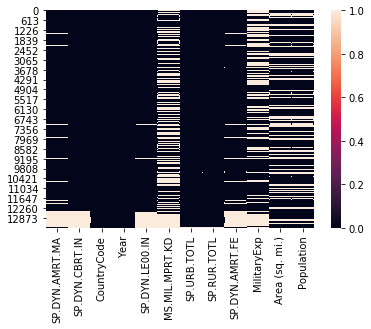

In [256]:
from seaborn import heatmap
heatmap(tot2.isnull())

#### Intermediate saving of the dataset

In [257]:
tot2.to_csv(path_or_buf='./part/partialDF', index=False)

In [258]:
tot2 = pd.read_csv('./part/partialDF')
tot2.head()

,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,CountryCode,Year,SP.DYN.LE00.IN,MS.MIL.MPRT.KD,SP.URB.TOTL,SP.RUR.TOTL,SP.DYN.AMRT.FE,MilitaryExp,Area (sq. mi.),Population
0,357.705584,47.697888,ARB,1960,46.847059,5.380000e+08,28937699.0,63558203.0,298.935703,NaN,NaN,NaN
1,261.118888,40.017001,CSS,1960,62.271795,NaN,1324191.0,2866619.0,201.475579,NaN,NaN,NaN
2,201.048873,19.117435,CEB,1960,67.823762,2.139000e+09,40680946.0,50720637.0,124.749727,NaN,NaN,NaN
3,446.838421,26.362350,EAS,1960,48.298317,5.344000e+09,231871389.0,799992005.0,326.366329,NaN,NaN,NaN
4,478.537086,26.635950,EAP,1960,45.549658,3.535000e+09,151665806.0,744827185.0,353.252556,NaN,NaN,NaN


In [259]:
dens = pd.read_csv('./part/density')

In [260]:
dens.head()

,CountryCode,Year,Density
0,ARB,1960,-9.249590e+07
1,CSS,1960,-4.190810e+06
2,CEB,1960,-9.140158e+07
3,EAS,1960,-1.042475e+09
4,EAP,1960,-8.964930e+08


In [261]:
tot3 = tot2.merge(dens, on=['CountryCode','Year'], how='left')

In [262]:
tot3.head()

,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,CountryCode,Year,SP.DYN.LE00.IN,MS.MIL.MPRT.KD,SP.URB.TOTL,SP.RUR.TOTL,SP.DYN.AMRT.FE,MilitaryExp,Area (sq. mi.),Population,Density
0,357.705584,47.697888,ARB,1960,46.847059,5.380000e+08,28937699.0,63558203.0,298.935703,NaN,NaN,NaN,-9.249590e+07
1,261.118888,40.017001,CSS,1960,62.271795,NaN,1324191.0,2866619.0,201.475579,NaN,NaN,NaN,-4.190810e+06
2,201.048873,19.117435,CEB,1960,67.823762,2.139000e+09,40680946.0,50720637.0,124.749727,NaN,NaN,NaN,-9.140158e+07
3,446.838421,26.362350,EAS,1960,48.298317,5.344000e+09,231871389.0,799992005.0,326.366329,NaN,NaN,NaN,-1.042475e+09
4,478.537086,26.635950,EAP,1960,45.549658,3.535000e+09,151665806.0,744827185.0,353.252556,NaN,NaN,NaN,-8.964930e+08


### Columns explanation

SP.DYN.LE00.IN: Life expectancy at birth

MS.MIL.MPRT.KD: Arms import

SP.URB.TOTL: Urban population

SP.RUR.TOTL: Rural population

SP.DYN.AMRT.FE: Mortality rate, female

SP.DYN.AMRT.MA: Mortality rate, male

SP.DYN.CBRT.IN: Birth rate (per 1000 people)

MilitaryExp: Military expenditure made in the Year

Density: population density

### Now I have to insert the count of all the attacks in one year in one single country.

In [263]:
cnt = pd.read_csv('./dataset/tot_year+country')

In [264]:
cnt["iyear"] = cnt["iyear"].astype(int)

In [265]:
cnt.dtypes

CountryCode     object
iyear            int64
cnt            float64
dtype: object

In [266]:
cnt.shape

(3509, 3)

In [267]:
tot4 = tot3.merge(cnt, left_on=['CountryCode','Year'], right_on=['CountryCode','iyear'], how='left')

In [268]:
tot4

,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,CountryCode,Year,SP.DYN.LE00.IN,MS.MIL.MPRT.KD,SP.URB.TOTL,SP.RUR.TOTL,SP.DYN.AMRT.FE,MilitaryExp,Area (sq. mi.),Population,Density,iyear,cnt
0,357.705584,47.697888,ARB,1960,46.847059,5.380000e+08,28937699.0,6.355820e+07,298.935703,NaN,NaN,NaN,-9.249590e+07,NaN,NaN
1,261.118888,40.017001,CSS,1960,62.271795,NaN,1324191.0,2.866619e+06,201.475579,NaN,NaN,NaN,-4.190810e+06,NaN,NaN
2,201.048873,19.117435,CEB,1960,67.823762,2.139000e+09,40680946.0,5.072064e+07,124.749727,NaN,NaN,NaN,-9.140158e+07,NaN,NaN
3,446.838421,26.362350,EAS,1960,48.298317,5.344000e+09,231871389.0,7.999920e+08,326.366329,NaN,NaN,NaN,-1.042475e+09,NaN,NaN
4,478.537086,26.635950,EAP,1960,45.549658,3.535000e+09,151665806.0,7.448272e+08,353.252556,NaN,NaN,NaN,-8.964930e+08,NaN,NaN
5,197.265489,18.838713,EMU,1960,69.273711,3.794000e+09,164803125.0,1.005934e+08,112.902532,9.333489e+09,NaN,NaN,-2.653965e+08,NaN,NaN
6,225.612571,22.141599,ECS,1960,67.030027,7.227000e+09,369124164.0,2.974179e+08,126.707013,NaN,NaN,NaN,-6.674890e+08,NaN,NaN
7,257.988633,30.390165,ECA,1960,61.210531,1.315000e+09,58762823.0,9.560755e+07,155.338176,NaN,NaN,NaN,-1.553174e+08,NaN,NaN
8,194.192923,18.579592,EUU,1960,69.279544,6.191000e+09,250665877.0,1.588326e+08,114.967322,1.890011e+10,NaN,NaN,-4.094985e+08,NaN,NaN
9,474.478846,46.458639,FCS,1960,41.411819,3.140000e+08,21364371.0,9.804321e+07,417.206737,NaN,NaN,NaN,-1.203546e+08,NaN,NaN


In [269]:
tot4[tot4.cnt.isnull()]

,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,CountryCode,Year,SP.DYN.LE00.IN,MS.MIL.MPRT.KD,SP.URB.TOTL,SP.RUR.TOTL,SP.DYN.AMRT.FE,MilitaryExp,Area (sq. mi.),Population,Density,iyear,cnt
0,357.705584,47.697888,ARB,1960,46.847059,5.380000e+08,28937699.0,6.355820e+07,298.935703,NaN,NaN,NaN,-9.249590e+07,NaN,NaN
1,261.118888,40.017001,CSS,1960,62.271795,NaN,1324191.0,2.866619e+06,201.475579,NaN,NaN,NaN,-4.190810e+06,NaN,NaN
2,201.048873,19.117435,CEB,1960,67.823762,2.139000e+09,40680946.0,5.072064e+07,124.749727,NaN,NaN,NaN,-9.140158e+07,NaN,NaN
3,446.838421,26.362350,EAS,1960,48.298317,5.344000e+09,231871389.0,7.999920e+08,326.366329,NaN,NaN,NaN,-1.042475e+09,NaN,NaN
4,478.537086,26.635950,EAP,1960,45.549658,3.535000e+09,151665806.0,7.448272e+08,353.252556,NaN,NaN,NaN,-8.964930e+08,NaN,NaN
5,197.265489,18.838713,EMU,1960,69.273711,3.794000e+09,164803125.0,1.005934e+08,112.902532,9.333489e+09,NaN,NaN,-2.653965e+08,NaN,NaN
6,225.612571,22.141599,ECS,1960,67.030027,7.227000e+09,369124164.0,2.974179e+08,126.707013,NaN,NaN,NaN,-6.674890e+08,NaN,NaN
7,257.988633,30.390165,ECA,1960,61.210531,1.315000e+09,58762823.0,9.560755e+07,155.338176,NaN,NaN,NaN,-1.553174e+08,NaN,NaN
8,194.192923,18.579592,EUU,1960,69.279544,6.191000e+09,250665877.0,1.588326e+08,114.967322,1.890011e+10,NaN,NaN,-4.094985e+08,NaN,NaN
9,474.478846,46.458639,FCS,1960,41.411819,3.140000e+08,21364371.0,9.804321e+07,417.206737,NaN,NaN,NaN,-1.203546e+08,NaN,NaN


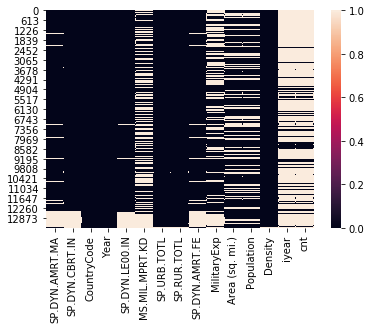

In [270]:
from seaborn import heatmap
heatmap(tot4.isnull())

In [271]:
tot4.to_csv(path_or_buf='./part/DF1sthyp', index=False)

In [272]:
tot4 = pd.read_csv('./part/DF1sthyp')

## We can get rid of the records where we have missing values for the life expectance, mortality rate (male), mortality rate (female) and birth rate
Let's remind the associated Codes:
- Life Expectancy: <strong>SP.DYN.LE00.IN</strong>
- Mortality Rate (male): <strong>SP.DYN.AMRT.MA</strong>
- Mortality Rate (female): <strong>SP.DYN.AMRT.FE</strong>
- Birth Rate: <strong>SP.DYN.CBRT.IN</strong>

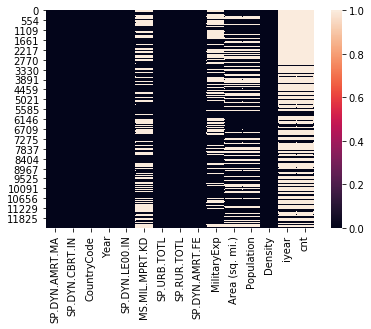

In [273]:
tot4 = tot4.dropna(subset=['SP.DYN.LE00.IN', 'SP.DYN.AMRT.MA', 'SP.DYN.AMRT.FE', 'SP.DYN.CBRT.IN'])
heatmap(tot4.isnull())

As we can see, we lost just about 1000 samples, over almost 12.000; that's a reasonable compromise

## Since the missing values about arms import and military expenditures are too much (about half of the records), we cannot just drop them; so we try to mitigate this problem by substituting the NaN values with the mean of the recorded values
Again, let's remind the Codes we have to work on:
- arms import: <strong>MS.MIL.MPRT.KD</strong>
- military expenditures: <strong>MilitaryExp</strong>

In [274]:
exp_not_nans = tot4.dropna(subset=['MilitaryExp']) #keep track of the not NaNs, on which we'll perform the mean
arms_not_nans = tot4.dropna(subset=['MS.MIL.MPRT.KD']) #same for this column
exp_mean = exp_not_nans['MilitaryExp'].mean() 
arms_mean = arms_not_nans['MS.MIL.MPRT.KD'].mean()
tot4['MilitaryExp'] = tot4['MilitaryExp'].replace(np.nan, exp_mean)
tot4['MS.MIL.MPRT.KD'] = tot4['MS.MIL.MPRT.KD'].replace(np.nan, arms_mean)

In [275]:
del tot4['iyear']

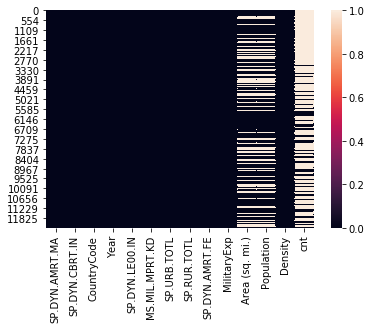

In [277]:
heatmap(tot4.isnull())

### About the Area and the Population, there are some missing values for a little amount of countries; since it's a small value, we can just drop these records

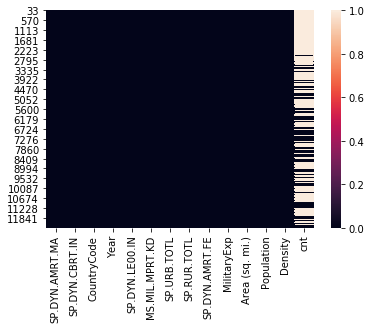

In [280]:
tot4 = tot4.dropna(subset=['Area (sq. mi.)', 'Population'])
heatmap(tot4.isnull())

As we can see, the number of samples has almost no variation.

## Finally, we can notice that we have some records for which we don't have the number of attacks carried out in that year (cnt); since the point of terrorism is to make the world know about the attacks, it's a good assumption to think no relevant activities have been carried out. So that, we'll substitute the NaNs with a 0. 

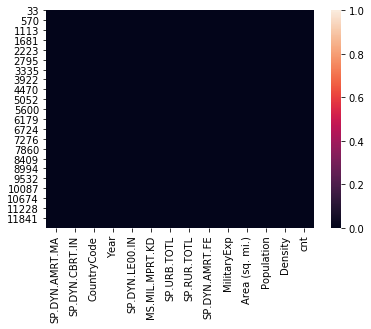

In [281]:
tot4['cnt'] = tot4['cnt'].replace(np.nan, 0)
heatmap(tot4.isnull())

In [56]:
tot4[tot4.Density < 0].CountryCode.unique()

array(['ARB', 'CSS', 'CEB', 'EAS', 'EAP', 'EMU', 'ECS', 'ECA', 'EUU',
       'FCS', 'HPC', 'HIC', 'NOC', 'OEC', 'LCN', 'LAC', 'LDC', 'LMY',
       'LIC', 'LMC', 'MEA', 'MNA', 'MIC', 'NAC', 'OED', 'OSS', 'PSS',
       'SST', 'SAS', 'SSF', 'SSA', 'UMC', 'WLD', 'CHI', 'ZAR', 'COG',
       'MNE', 'MMR', 'ROM', 'SSD', 'TMP', 'WBG'], dtype=object)

When creating the density dataset (in the script 'Density creation') we assigned a negativ density to the CountryCodes that didn't match. Here we look at them, and we see that they correspond to agglomerations of states (Arab World, Caribbean small states, Central Europe and the Baltics...), so we don't care about them, because the single states are ALREADY in our dataset, so we delete them.

In [282]:
tot4 = tot4[tot4.Density > 0]

In [285]:
tot4.head()

,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,CountryCode,Year,SP.DYN.LE00.IN,MS.MIL.MPRT.KD,SP.URB.TOTL,SP.RUR.TOTL,SP.DYN.AMRT.FE,MilitaryExp,Area (sq. mi.),Population,Density,cnt
33,604.5970,51.276,AFG,1960,32.328512,4.000000e+07,739462.0,8255331.0,551.1210,2.252607e+10,647500.0,31056997.0,13.891572,0.0
34,160.4806,42.240,ALB,1960,62.254366,6.200000e+07,493982.0,1114818.0,151.0588,2.252607e+10,28748.0,3581655.0,55.962154,0.0
35,373.1320,49.671,DZA,1960,46.135122,1.451501e+09,3394205.0,7730687.0,323.2800,2.252607e+10,2381740.0,32930091.0,4.670910,0.0
36,565.4100,54.423,AGO,1960,32.984829,1.451501e+09,550013.0,4720831.0,500.8860,2.252607e+10,1246700.0,12127071.0,4.227837,0.0
38,255.1080,23.682,ARG,1960,65.215537,1.030000e+08,15177907.0,5441168.0,156.2470,2.252607e+10,2766890.0,39921833.0,7.452076,0.0


### The dataset is finally completed and saved.

In [286]:
tot4.to_csv(path_or_buf='./part/DF1sthypTOT', index=False)

In [287]:
# df = pd.read_csv('./part/DF1sthypTOT')

import json

collection = db['DF1sthypTOT']
print("Collection created")

records = json.loads(tot4.T.to_json()).values()
db.UrbPopulation.insert_many(records) #columns name must not be with points

In [288]:
df.dtypes

SP.DYN.AMRT.MA    float64
SP.DYN.CBRT.IN    float64
CountryCode        object
Year                int64
SP.DYN.LE00.IN    float64
MS.MIL.MPRT.KD    float64
SP.URB.TOTL       float64
SP.RUR.TOTL       float64
SP.DYN.AMRT.FE    float64
MilitaryExp       float64
Area (sq. mi.)    float64
Population        float64
Density           float64
cnt               float64
dtype: object

In [289]:
df.shape

(8332, 14)